# Dogs vs Cats


Dataset for this example comes from the [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data) Dogs vs Cats competition. 

## Download the data

In [1]:
!mkdir data
!wget https://www.dropbox.com/s/15knprbjz3logbg/dogscats.zip -P ./data/
!unzip data/dogscats.zip -d ./data > /dev/null

--2018-06-01 20:25:45--  https://www.dropbox.com/s/15knprbjz3logbg/dogscats.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.7.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.7.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/eq9phs1x1vdxf2qiYMmrJ21pfMieKdxuR8f5KBR5SEQlhGlaWo8DJzeh40iOs01e/file [following]
--2018-06-01 20:25:46--  https://dl.dropboxusercontent.com/content_link/eq9phs1x1vdxf2qiYMmrJ21pfMieKdxuR8f5KBR5SEQlhGlaWo8DJzeh40iOs01e/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.7.6, 2620:100:601a:6::a27d:706
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.7.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857214334 (818M) [application/zip]
Saving to: ‘./data/dogscats.zip’

dogscats.zip        100%[===================>] 817.50M  31.2MB/s    in 25s     

2018-06-01 20:

In [0]:
!rm ./data/dogscats.zip

organization of the dataset:

![alt text](http://crysa.fzu.cz/karla/dl_img/dogscats_tree.png)

The training archive contains 25,000 images of dogs and cats split into two sets: the train directory contains 23,000 labeled images, while the valid directory contains labeled 2000 images. There are 12,500 unlabeled images in tghe test1 directory

## Load libraries

In [0]:
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import numpy as np
from matplotlib import patches, patheffects

In [4]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Convolution2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


 (preprocess_function doesn't work in keras 2.1.5)

In [23]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.6'

In [25]:
from tensorflow.python import keras as kerastf
kerastf.__version__

'2.1.5-tf'

In [0]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax
  
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
  
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
           verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

## VGG16 model

In the first step, we will use a model that has been fully created before, an 
has been trained to recognise a wide variety (1000 categories) of images.

We will use **VGG** model, which won the [Imagenet](http://www.image-net.org/challenges/LSVRC/) competition in 2014. After the competition, the [VGG team](http://www.robots.ox.ac.uk/~vgg/) released two CNN models, a 16-layer model (VGG 16) and a 19-layer model (VGG 19).   
\[for more details, you can refer to the original [paper](https://arxiv.org/abs/1409.1556)\] 

The VGG models are not longer state-of-the-art by a few percentage points. Nevertheless,
they are very poverful models, and, compared to newer models, simple to create and understand.

We are going to use the smaller and faster model (VGG 16).

In [6]:
model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 16s 0us/step


In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

First, we need to get some image data and prepare it to be loaded into network.


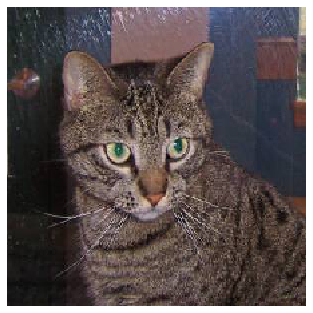

In [7]:
img = load_img('data/dogscats/train/cats/cat.1.jpg', target_size=(224, 224)) # load an image from file 
x = img_to_array(img) # convert it into a numpy array
x = x.reshape((1,) + x.shape) # reshape data for the model
img_data = preprocess_input(x) # prepare the image for the VGG model

show_img(img)

Now, we can call the predict() function on the model in order to get a prediction of the probability of the image belonging to each of the 1000 image categories.

In [8]:
preds = model.predict(x)

# decode the results into a list of tuples (class, description, probability)
decode_predictions(preds, top=3)[0]

40960/35363 [==================================] - 0s 3us/step


[('n02123045', 'tabby', 0.45946732),
 ('n02123159', 'tiger_cat', 0.2790552),
 ('n02124075', 'Egyptian_cat', 0.23686291)]

## Transfer learning

We won't be able to categorise cats vs dogs competition with an Imagenet model alone, since 'cat' and 'dog' are not categories in Imagenet - instead there are several categories for individual breeds.

We will remove the last fully connected layer and use the rest of the VGG 16 to extract features for the new dataset and train a classifier on top of them.

In [9]:
base_model = VGG16(weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 8s 0us/step


Define new layers on top of the the last fully connected layer in VGG 16 and combine them with the original model:



In [0]:
x = base_model.output
x = GlobalAveragePooling2D()(x) # this converts our 3D feature maps to 1D feature vectors
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x) # number of classes = 1: dog/not dog
model = Model(inputs=base_model.input, outputs=predictions)

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

Make sure to train only the newly added layers and compile the model:




In [0]:
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer=Adam(lr=1e-3),    
                loss='binary_crossentropy', 
                metrics=['accuracy'])

In [0]:
SZ = 170 # desired image size
BS = 64 # batch size

In [13]:
train_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input   
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory( # each category is in a separate folder
  './data/dogscats/train',
  target_size=(SZ, SZ),
  batch_size=BS, class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
  './data/dogscats/valid',
  target_size=(SZ, SZ),
  batch_size=BS, class_mode='binary',
  shuffle = False
)


Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [14]:
%%time
model.fit_generator(
    train_generator, 
    train_generator.n // BS, 
    epochs=3, 
    workers=8,
    validation_data=validation_generator, 
    validation_steps=validation_generator.n // BS)

Epoch 1/3
359/359 [==============================] - 152s 423ms/step - loss: 0.2164 - acc: 0.9442 - val_loss: 0.0638 - val_acc: 0.9753
Epoch 2/3
298/359 [=======================>......] - ETA: 22s - loss: 0.0796 - acc: 0.9693

359/359 [==============================] - 147s 408ms/step - loss: 0.0781 - acc: 0.9697 - val_loss: 0.0549 - val_acc: 0.9798
Epoch 3/3
359/359 [==============================] - 147s 410ms/step - loss: 0.0654 - acc: 0.9755 - val_loss: 0.0539 - val_acc: 0.9788
CPU times: user 7min 33s, sys: 1min 3s, total: 8min 36s
Wall time: 7min 26s


As the Cats vs Dogs dataset is highly similar to the original Imagenet dataset, we were able to achieve pretty good accuracy. 

In [0]:
model.save_weights('dogscats_vgg_3e.h5') 

## Finetune model

With a large enough dataset, we can try to fine-tune the weights of the pre-trained network via backpropagation. This can help if your dataset is different from the pre-trained dataset.

In [0]:
def freeze_upto(model, layers_to_freeze, lr=1e-5):
  """Freeze the bottom layers and retrain the remaining top layers.
     model: keras model
  """
  for layer in model.layers[:layers_to_freeze]:
     layer.trainable = False
  for layer in model.layers[layers_to_freeze:]:
     layer.trainable = True
  #model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
  model.compile(optimizer=SGD(lr=lr, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
freeze_upto(model, 25) # set the first 25 layers of VGG 16 non-trainable (up to the last conv block, which will be trainable)


![alt text](http://crysa.fzu.cz/karla/dl_img/vgg_finetune.png)


In [18]:
%%time
model.fit_generator(
    train_generator, 
    train_generator.n // BS, 
    epochs=1, 
    workers=5,
    validation_data=validation_generator, 
    validation_steps=validation_generator.n // BS)

Epoch 1/1
359/359 [==============================] - 146s 406ms/step - loss: 0.0599 - acc: 0.9776 - val_loss: 0.0539 - val_acc: 0.9788
CPU times: user 3min 4s, sys: 1min 24s, total: 4min 28s
Wall time: 2min 25s


In [0]:
model.save_weights('dogscats_vgg_finetune_1e.h5') 

In [0]:
#model.load_weights('dogscats_vgg_finetune_1e.h5') 

## Check predictions for the validation set

In [21]:
y_true = validation_generator.classes
y_true

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [0]:
preds = model.predict_generator(validation_generator)

In [0]:
y_pred = np.ravel(np.around(preds))

In [0]:
from sklearn.metrics import confusion_matrix
import itertools

In [0]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [0]:
cnf_matrix = confusion_matrix(y_true, y_pred)

[[981  19]
 [ 23 977]]


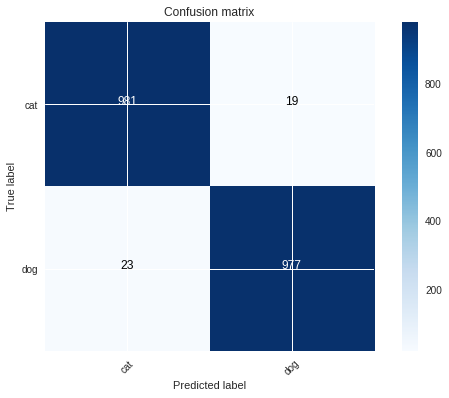

In [27]:
plot_confusion_matrix(cnf_matrix, ['cat', 'dog'])


Some correctly predicted images

In [0]:
filenames = validation_generator.filenames

In [0]:
correct = np.where(y_pred == y_true)[0]
idx = np.random.choice(correct, 16, replace=False)

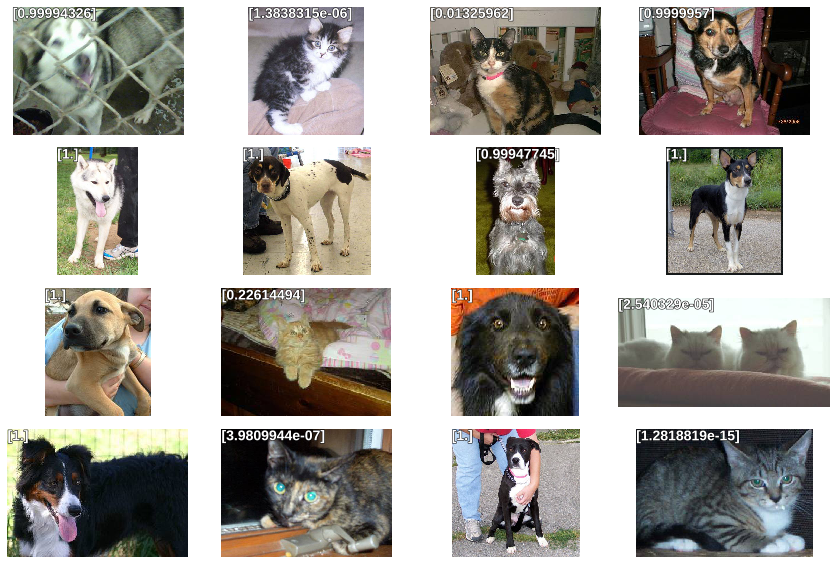

In [30]:
fig, axes = plt.subplots(4, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima = load_img('./data/dogscats/valid/'+filenames[idx[i]]) 
    prob = preds[idx[i]]
    show_img(ima, ax=ax)
    draw_text(ax, (0,0), prob)
plt.tight_layout()

...and some incorrectly predicted ones:

In [0]:
incorrect = np.where(y_pred != y_true)[0]
idx = np.random.choice(incorrect, 16, replace=False)

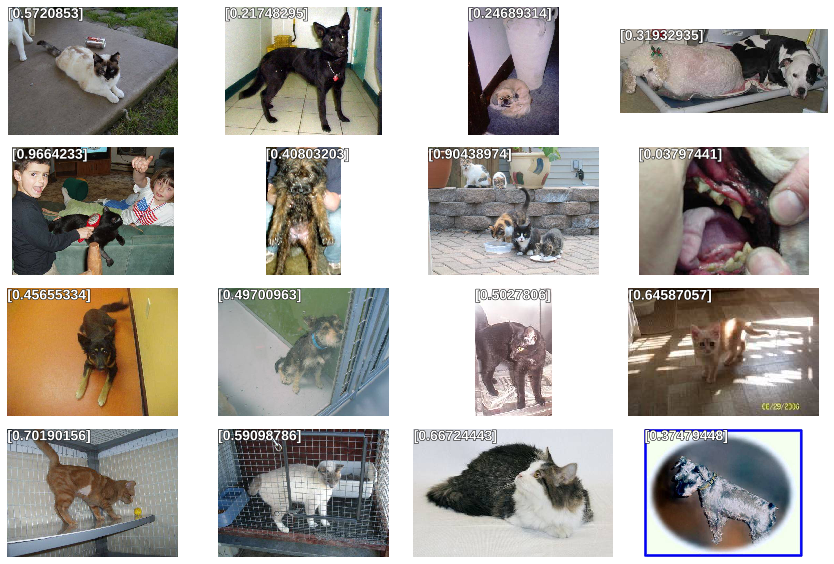

In [32]:
fig, axes = plt.subplots(4, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima = load_img('./data/dogscats/valid/'+filenames[idx[i]])
    prob = preds[idx[i]]
    show_img(ima, ax=ax)
    draw_text(ax, (0,0), prob)
plt.tight_layout()

## Predictions for the test dataset


In [0]:
p = Path('./data/dogscats/test1/')
imglst = list(p.glob('*.jpg'))

In [0]:
X_test = []   
for image in imglst[:2000]:
    X_test.append(cv2.resize(cv2.imread(str(image)), (SZ,SZ), 
                             interpolation=cv2.INTER_CUBIC))

In [0]:
test_generator = test_datagen.flow(
  np.array(X_test),  
  batch_size=BS,
  shuffle=False
)

In [36]:
prediction_probabilities = model.predict_generator(test_generator, verbose=1)

32/32 [==============================] - 11s 357ms/step


Unsure:

In [0]:
unsure_idx = np.where((prediction_probabilities > 0.2) & (prediction_probabilities < 0.8))[0]

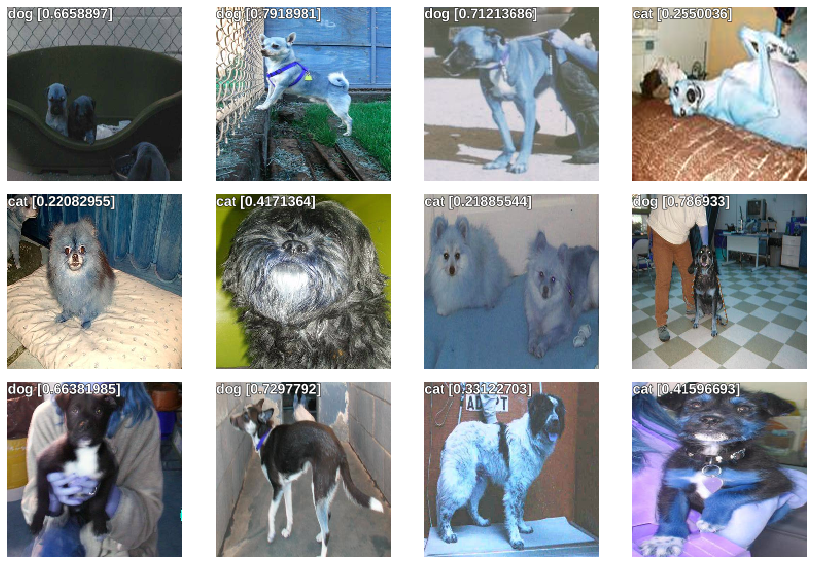

In [38]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima= X_test[unsure_idx[i]]
    prob = prediction_probabilities[unsure_idx[i]]
    if prob < 0.5:
      b = " ".join(["cat", str(prob)])
    else:
      b = " ".join(["dog", str(prob)])
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

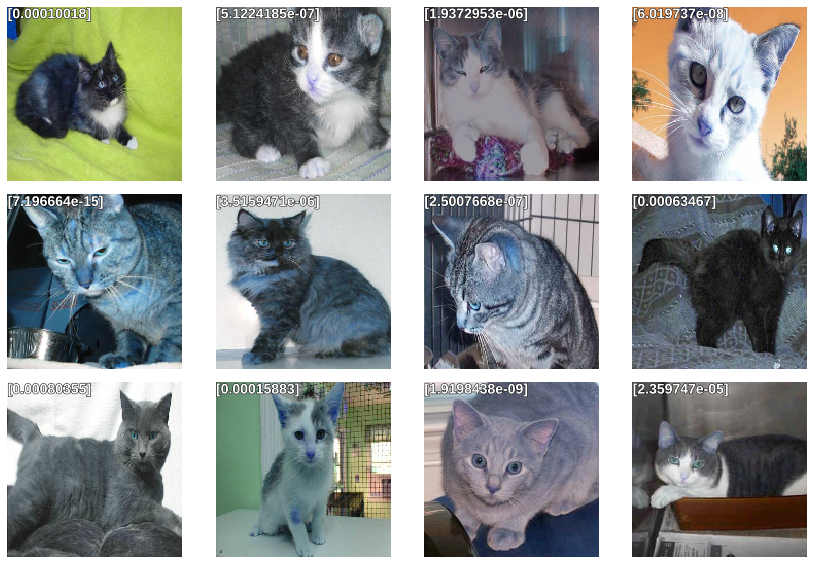

In [39]:
cats_idx = np.where(prediction_probabilities < 0.001)[0]
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima= X_test[cats_idx[i]]
    b = prediction_probabilities[cats_idx[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

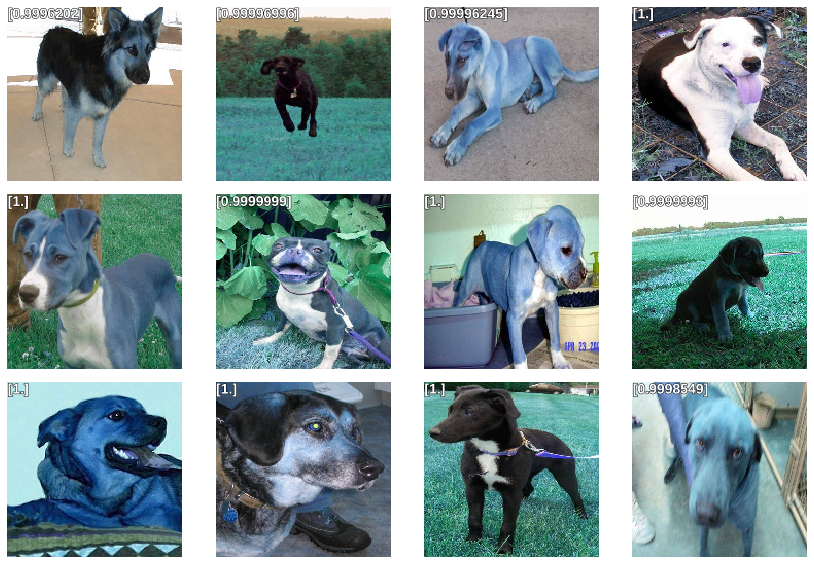

In [40]:
dogs_idx = np.where(prediction_probabilities > 0.999)[0]
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima= X_test[dogs_idx[i]]
    b = prediction_probabilities[dogs_idx[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

## Data augumentation

Not enough data? In order to get the most from our training data, we can augument the dataset by a number of random transformations, so that our model will never see the same image twice. This helps prevent overfitting and makes the model generalize better.

In [0]:
datagen =  ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    channel_shift_range = 25
)

Let's generate some pictures using this transformations and save them into a temporary folder to see what the transformations are doing:

In [0]:
img = load_img('data/dogscats/train/cats/cat.1.jpg')  # this is a PIL image
x = img_to_array(img) 
x = x.reshape((1,) + x.shape) 

In [0]:
!mkdir preview

In [0]:
#!rm preview/*

In [0]:
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', 
                          save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely


In [0]:
p = Path('preview')
images = list(p.glob('*.jpeg'))

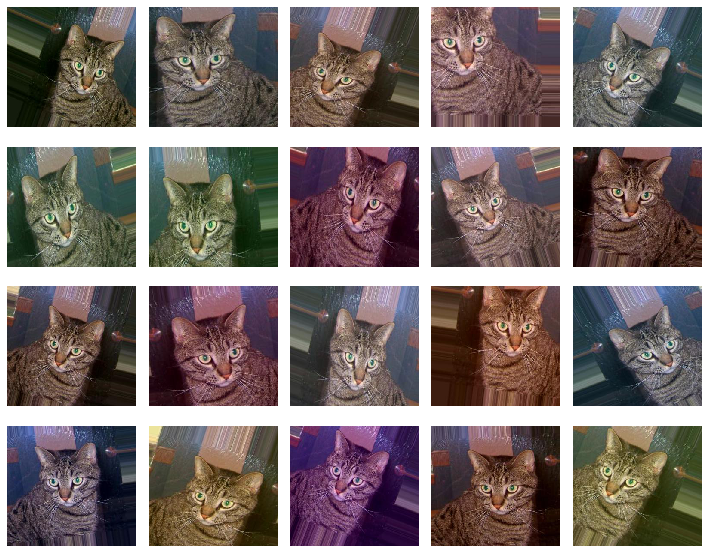

In [46]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    img = load_img(str(images[i]))
    ax = show_img(img, ax=ax)
plt.tight_layout()

## Extra: VGG 16 model from scratch

How would it it look like if we wanted to build VGG 16 from scratch?

In [0]:
def ConvBlock (layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [0]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [0]:
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((1,1,3))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]  

In [0]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(224,224,3)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

## download files

In [0]:

from google.colab import files

In [0]:
files.download('dogscats_vgg_3e.h5')

In [0]:
files.download('dogscats_vgg_finetune_1e.h5')